# Model Predictive Control for DED using GAMMA, Pytorch Implementation
created on 5/22/2024

In [1]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# from scipy.optimize import minimize, Bounds

# For TiDE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F

import os
import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward

from RobustMPC_pytorch import RMPC
from nn_functions import surrogate
from torchmin import minimize as pytorch_minimize
from scipy.optimize import minimize, Bounds

from moving_average import moving_average_1d
import copy

from GAMMA_obj import GAMMA_obj



cuda is available


### Load pre-trained model

In [2]:
with open('TiDE_params_single_track_square_MV_lp_less_cov.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
P = 50
window = 50

### Build class for ML surrogate

In [3]:
'''
inputs:
    nominal_param: nominal parameters saved from nominal_preparation
    nominal_NN   : a complete nn.module model with the pretrained parameters are loaded
'''
TiDE = surrogate(nominal_params, nominal_TiDE)

### Load reference trajectory

### Objective function

In [4]:
def RMPC_obj_wo_constraint(u_hat0:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_future_fix:torch.tensor, # future u values within the control horizon but not the design variables
                u_past:torch.tensor, # past u
                x_past_fix: torch.tensor, # past state of x, size (N,window)
                x_past:torch.tensor, # past state that changes
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal # NN object we're using
):
    ''' 
    All the data that goes into this module should be normalized
    '''    
    
    u_hat = u_hat0.reshape(-1,1)
    u_hat_in = u_hat0.unsqueeze(0)
        
    x_hat = NN_Nominal.forward(u_hat, u_future_fix, u_past, x_past_fix, x_past)

    # compute objective value
    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    #u = u_hat_temp[0].reshape(-1,1)
    u = u_past[-1].reshape(-1,1)
    u_hat1 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u 
    
    #Obj = 1000 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 100*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)
    
    Obj = 1 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 10*torch.sum((u_hat1[:-1]-u_hat_temp)**2)

    return Obj

In [5]:
def RMPC_obj_wo_constraint_scipy(u_hat0:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_future_fix:torch.tensor, # future u values within the control horizon but not the design variables
                u_past:torch.tensor, # past u
                x_past_fix: torch.tensor, # past state of x, size (N,window)
                x_past:torch.tensor, # past state that changes
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal # NN object we're using
):
    ''' 
    All the data that goes into this model should be normalized
    '''    
    u_hat = torch.tensor(u_hat0.reshape(-1,1),requires_grad=True,dtype=torch.float32)
    u_hat_in = u_hat.unsqueeze(0)
    x_hat = NN_Nominal.forward(u_hat, u_future_fix, u_past, x_past_fix, x_past)

    # compute objective value

    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    u = u_past[-1].reshape(-1,1)
    u_hat1 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
    Obj = 10 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat1[:-1]-u_hat_temp)**2)
    Obj.backward()

    
    return Obj.item(), u_hat.grad.numpy().reshape(-1)

### Single iteration

#### Run GAMMA for initialization

In [6]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 2500
window = 50
sim_interval = 5
init_runs = 50

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)

 32%|███▏      | 81/250 [00:03<00:06, 25.69it/s]


KeyboardInterrupt: 

#### Fix covariates as the configuration is given

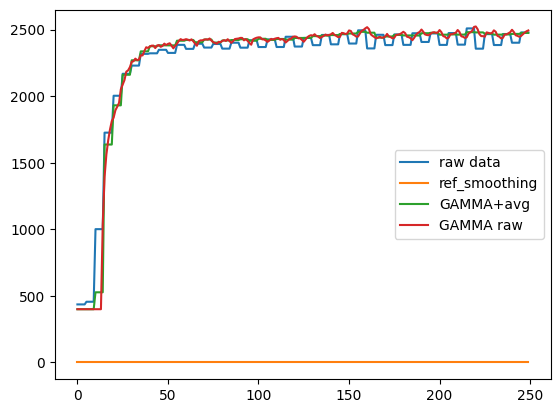

In [ ]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)
# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)
# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

# replace the reference with fixed temperature
mp_temp_ref = torch.zeros([6120],dtype=torch.float32)


# manually fix reference
mp_temp_ref[50:65] = torch.tensor(mp_temp_raw[50:65],dtype=torch.float32)

plt.plot(np.repeat(mp_temp_raw[0:50],5), label='raw data')
plt.plot(np.repeat(mp_temp_ref[0:50],5), label='ref_smoothing')
plt.plot(np.repeat(init_avg,5), label='GAMMA+avg')
plt.plot(GAMMA_class.melt_pool_temp_save["temp"].values, label='GAMMA raw')
plt.legend()


### Class for GAMMA_MPC

In [ ]:
class GAMMA_MPC():
    def __init__(self,
                 GAMMA_class,                 # GAMMA class that has been initialized and run through the first sim_interval*window iterations
                 TiDE,                        # TiDE model that includes scalers and forward function
                 MPC_obj_fun,                 # Objective function of MPC. Should be compatible with TiDE
                 x_ref_all,                   # Reference trajectory for x (melt pool temperature)
                 window,                      # window size
                 P,                           # Horizon size
                 fix_cov_all,                 # fix covariates (original scale) from the beginning to the end. It should be fixed once the toolpath is given
                 x_past,                      # past melt pool temperature using MPC timesteps, in original scale
                 u_past,                      # past laser power using MPC timesteps.
                 ):
        
        x_past_in = x_past[-window:]
        u_past_in = u_past[-window:,0].reshape(-1,1)
        
        
        self.GAMMA = GAMMA_class
        self.TiDE = TiDE
        self.window = window
        self.obj = MPC_obj_fun
        self.ref = x_ref_all
        self.P = P
        self.fix_cov_all = fix_cov_all
        self.x_past = x_past_in
        self.u_past = u_past_in
        self.MPC_counter = 50
        self.x_hat_current = x_past[-1]
        self.x_sys_current = x_past[-1]
  
        
        # save data
        self.x_past_save = x_past.reshape(-1,1)
        self.u_past_save = u_past.reshape(-1,1)
        self.NN_pred_save = x_past.reshape(-1,1)
        self.save_time = []
        
        return None
    
    def MPC_run_one_step_pytorch(self):
        
        # select the counter part of reference
        mp_temp_ref = self.ref[self.MPC_counter:self.MPC_counter + self.P] 
        # scale reference
        mp_temp_ref_part_s = self.TiDE.scaler_y(mp_temp_ref)
        # scale past temperature
        mp_temp_past_part_s = self.TiDE.scaler_y(self.x_past).transpose(1,0)
        # select past fix covariate
        fix_cov_past = self.fix_cov_all[self.MPC_counter-window:self.MPC_counter,:]
        
        # scale past fix covariate
        # for all the covariates
        # fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2,3,4,5,6])
        # for partial covariates
        fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2])
        
        # select future fix covariate
        fix_cov_future = self.fix_cov_all[self.MPC_counter:self.MPC_counter+self.P,:]
        # scale future fix covariate
        # for all the covariates
        # fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2,3,4,5,6])
        # for partial covariates
        fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2])
        # scale past laser power input
        past_laser_power_s = TiDE.scaler_x(self.u_past, dim_id=[3])
        
        
        # Adjust reference if there is a layer switch
        # if torch.any(fix_cov_future[6,:]==0):
        #     is_zero = fix_cov_future[6,:] == 0
        #     is_zero_int = is_zero.int()
        #     cut_off_indicator = torch.argmax(is_zero_int)
        #     print(cut_off_indicator)
        #     mp_temp_ref_part_s[cut_off_indicator:] = mp_temp_ref_part_s[cut_off_indicator-1]

        # optimization
        time1 = time.time()
        solution_s = pytorch_minimize(lambda u:self.obj(u,fix_cov_future_s,past_laser_power_s,fix_cov_past_s, mp_temp_past_part_s,mp_temp_ref_part_s,P,TiDE),torch.zeros((P,1)),method="l-bfgs")
        time2 = time.time()
        
        
        # scale solution to original scale
        solution = TiDE.inv_scaler_x(solution_s.x, dim_id = [3])
        
        # predict MP temp
        mp_hat_opt_s = TiDE.forward(solution_s.x, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
        # scale MP temp to original scale
        mp_hat_opt = TiDE.inv_scaler_y(mp_hat_opt_s)
        
        
        # plt.figure()
        # plt.plot(mp_temp_ref, label="ref")
        # plt.plot(mp_hat_opt.detach().numpy().reshape(-1,1), label="TiDE pred")
        # plt.legend()
        
        # plt.figure()
        # plt.plot(solution)
        # print(solution_s)
        
        # aaa
        
        
        # apply anciliary controller
        rmpc = 0
        if rmpc:
            K_ac = -1
            e = self.x_sys_current - self.x_hat_current
            u_applied = float(solution[0]) + float(K_ac*e)
            x_current = self.GAMMA.run_sim_interval(u_applied)
        
        else:
        # simulate environment
            x_current = self.GAMMA.run_sim_interval(float(solution[0]))
   
        # update past
        self.x_past[0:-1] = copy.deepcopy(self.x_past[1:])
        self.x_past[-1] = x_current
        
        self.u_past[0:-1] = copy.deepcopy(self.u_past[1:])
        self.u_past[-1] = solution[0]
        
        self.save_time.append(time1-time2)
        
        self.x_hat_current = mp_hat_opt[0][0]
        self.x_sys_current = x_current
        
        self.MPC_counter += 1
               
        # save data
        self.x_past_save = torch.concatenate((self.x_past_save,copy.deepcopy(self.x_past[-1].reshape(-1,1))))
        self.u_past_save = torch.concatenate((self.u_past_save,copy.deepcopy(self.u_past[-1].reshape(-1,1))))
        self.NN_pred_save = torch.concatenate((self.NN_pred_save,mp_hat_opt.squeeze()[0].reshape(-1,1)))
        
        
  
        

        return None
    
    def MPC_run_one_step_scipy(self):
        
        # select the counter part of reference
        mp_temp_ref = self.ref[self.MPC_counter:self.MPC_counter + self.P] 
        # scale reference
        mp_temp_ref_part_s = self.TiDE.scaler_y(mp_temp_ref)
        # scale past temperature
        mp_temp_past_part_s = self.TiDE.scaler_y(self.x_past).transpose(1,0)
        # select past fix covariate
        fix_cov_past = self.fix_cov_all[self.MPC_counter-window:self.MPC_counter,:]
        # scale past fix covariate
        fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2,3,4,5,6])
        # select future fix covariate
        fix_cov_future = self.fix_cov_all[self.MPC_counter:self.MPC_counter+self.P,:]
        # scale future fix covariate
        fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2,3,4,5,6])
        # scale past laser power input
        past_laser_power_s = TiDE.scaler_x(self.u_past, dim_id = [6])
        
        # Adjust reference if there is a layer switch
        fix_cov_future_ref = self.fix_cov_all[self.MPC_counter:self.MPC_counter+self.P + 5,:]
        
        # if not torch.all(fix_cov_future_ref[:,2]==fix_cov_future_ref[0,2]):
        #     index = torch.where(fix_cov_future_ref[:,2] != fix_cov_future_ref[0,2])[0][0]
        #     if index >= 4:
        #         mp_temp_ref_part_s[0,index-6:] = mp_temp_ref_part_s[0,index-6]

        
        # optimization
        bounds = Bounds(lb=np.ones(P)*-1, ub=np.ones(P))
        solution_s = minimize(lambda u:RMPC_obj_wo_constraint_scipy(u,fix_cov_future_s,past_laser_power_s,fix_cov_past_s, mp_temp_past_part_s,mp_temp_ref_part_s,P,TiDE),np.zeros((P)),method="slsqp",jac=True, bounds=bounds)
        # scale solution to original scale
        if solution_s.success == False:
            print(f"not success on iteration {self.MPC_counter}")
            
        solution_s_torch = torch.tensor(solution_s.x.reshape(-1,1),dtype=torch.float32)
        solution = TiDE.inv_scaler_y(solution_s_torch)
        
        # predict MP temp
        mp_hat_opt_s = TiDE.forward(solution_s_torch, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
        # scale MP temp to original scale
        mp_hat_opt = TiDE.inv_scaler_y(mp_hat_opt_s)
        
        # simulate environment
        x_current = self.GAMMA.run_sim_interval(float(solution[0]))
        
        # update past
        self.x_past[0:-1] = copy.deepcopy(self.x_past[1:])
        self.x_past[-1] = x_current
        
        self.u_past[0:-1] = copy.deepcopy(self.u_past[1:])
        self.u_past[-1] = solution[0]
        
        
        
        # if self.MPC_counter >= 550:
        #     plt.figure()
        #     plt.plot(mp_hat_opt_s.detach().numpy(), label = "TiDE Prediction")
        #     plt.plot(mp_temp_ref_part_s.detach().numpy().squeeze(), label="reference")
            
        self.MPC_counter += 1

        # save data
        self.x_past_save = torch.concatenate((self.x_past_save,copy.deepcopy(self.x_past[-1].reshape(-1,1))))
        self.u_past_save = torch.concatenate((self.u_past_save,copy.deepcopy(self.u_past[-1].reshape(-1,1))))
        self.NN_pred_save = torch.concatenate((self.NN_pred_save,mp_hat_opt.squeeze()[0].reshape(-1,1)))
        # save data is problematic and need to be checked 

        return None

tensor(0.8902)

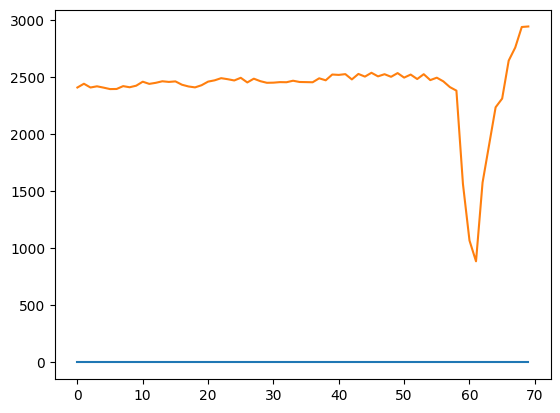

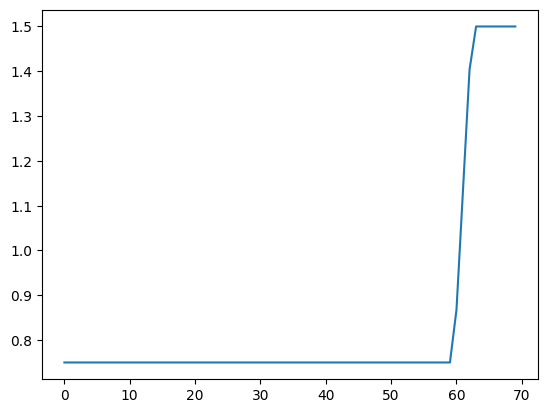

In [ ]:
plt.figure()
plt.plot(mp_temp_ref[550:620])
plt.plot(mp_temp_raw[550:620])
plt.figure()
plt.plot(fix_covariates[550:620,0])
mp_temp_raw[609]
fix_covariates[609,2]

In [ ]:
MPC_GAMMA = GAMMA_MPC(GAMMA_class, TiDE, RMPC_obj_wo_constraint, mp_temp_ref, window, P, fix_covariates, init_avg, laser_power_past)
N_step = 6196
for i in tqdm(range(N_step)):
    MPC_GAMMA.MPC_run_one_step_pytorch()

  1%|          | 64/6196 [01:09<1:51:05,  1.09s/it]


KeyboardInterrupt: 

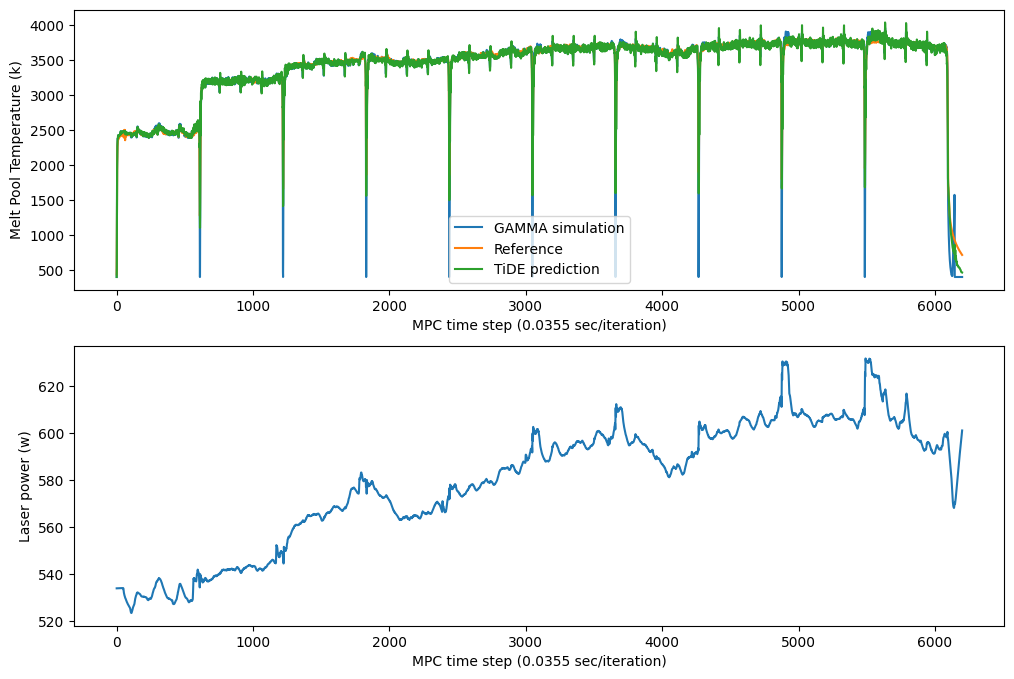

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
plt.plot(MPC_GAMMA.x_past_save[:N_step], label = "GAMMA simulation")
plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step], label="TiDE prediction")
plt.legend()
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.ylabel("Melt Pool Temperature (k)")

plt.subplot(2,1,2)
plt.plot(MPC_GAMMA.u_past_save[:N_step])
plt.ylabel("Laser power (w)")
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.show()

0.3507391333656976

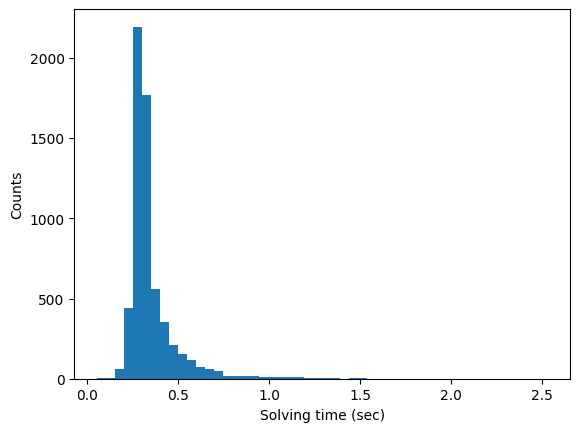

In [ ]:
time = np.array(MPC_GAMMA.save_time) * -1
plt.hist(time,50)
plt.xlabel("Solving time (sec)")
plt.ylabel("Counts")
np.mean(time)

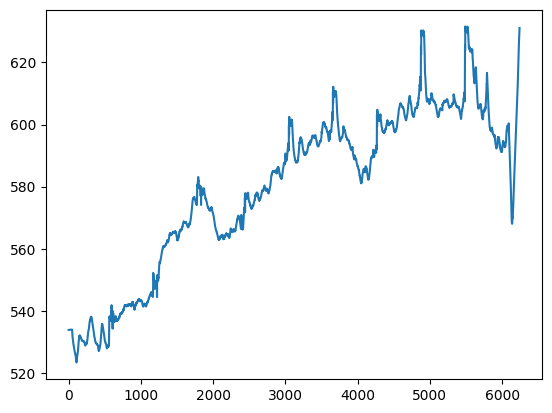

In [ ]:
plt.plot(MPC_GAMMA.u_past_save)

In [ ]:
gamma_result = MPC_GAMMA.x_past_save[:N_step]
ref = MPC_GAMMA.ref[:N_step]
TiDE_pred = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step]
LP = MPC_GAMMA.u_past_save[:N_step]


LP.shape

torch.Size([6200, 1])

In [ ]:
import pandas as pd

# Assuming the three variables are numpy arrays or lists
gamma_result = MPC_GAMMA.x_past_save[:N_step].squeeze()
ref = MPC_GAMMA.ref[:N_step]
TiDE_pred = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step].squeeze()
LP = MPC_GAMMA.u_past_save[:N_step].squeeze()

# Create a dictionary with the data
data = {
    'gamma_result': gamma_result,
    'ref': ref,
    'TiDE_pred': TiDE_pred,
    'LP': LP
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)


#### Pytorch minimize w/o input bounds


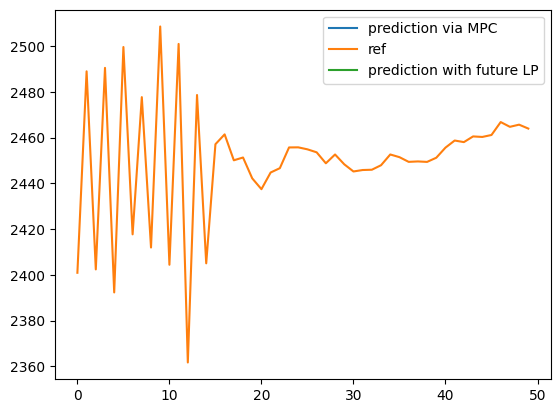

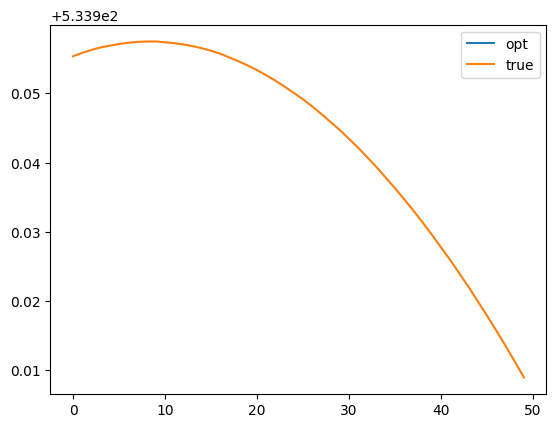

In [ ]:
#  === Initial Conditions: Values at time = k ===============
k = 50


# temporary ref 
mp_temp_ref_part = mp_temp_ref[k:k+P] + torch.tensor(np.linspace(0,30,50),dtype=torch.float32)

mp_temp_ref_part_s = TiDE.scaler_y(mp_temp_ref_part)

# past melt pool temperature
mp_temp_past_part = mp_temp_ref[k-window:k]
mp_temp_past_part_s = TiDE.scaler_y(mp_temp_past_part).transpose(1,0)

# assume the past history is the same as the first term at the first step
fix_cov_past = fix_covariates[k-window:k,:]
fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2])

# fix future covariate
fix_cov_future = fix_covariates[k:k+P,:]
fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2])

# past laser power: take the given ones first
past_laser_power = laser_power_ref[k-window:k]
past_laser_power_s = TiDE.scaler_x(past_laser_power,dim_id=3)
future_laser_power = laser_power_ref[k:k+P]
future_laser_power_s = TiDE.scaler_x(future_laser_power,dim_id=3)

# designed laser power
u_hat = torch.zeros((P,1),dtype=torch.float32)
solution = pytorch_minimize(lambda u:RMPC_obj_wo_constraint(u,fix_cov_future_s,past_laser_power_s,fix_cov_past_s, mp_temp_past_part_s,mp_temp_ref_part_s,P,TiDE),torch.zeros((P,1)),method="l-bfgs")

mp_hat_opt_s = TiDE.forward(solution.x, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_hat_opt = TiDE.inv_scaler_y(mp_hat_opt_s)
mp_real_s = TiDE.forward(future_laser_power_s, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_real = TiDE.inv_scaler_y(mp_real_s)
mp_hat_ini_guess_s = TiDE.forward(torch.ones((P,1)), fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s)
mp_hat_ini_guess = TiDE.inv_scaler_y(mp_hat_ini_guess_s)

plt.plot(mp_hat_opt.squeeze().detach().numpy(), label="prediction via MPC")
plt.plot(mp_temp_ref_part.numpy(), label="ref")
plt.plot(mp_real.detach().numpy().T, label='prediction with future LP')
# plt.plot(mp_hat_ini_guess.detach().numpy().T, label="prediction with initial guess")
plt.legend()
#plt.ylim([2200,2400])
plt.show()

plt.figure()
plt.plot(TiDE.inv_scaler_x(solution.x.detach(),dim_id=3),label='opt')
plt.plot(TiDE.inv_scaler_x(future_laser_power_s,dim_id=3),label='true')
plt.legend()



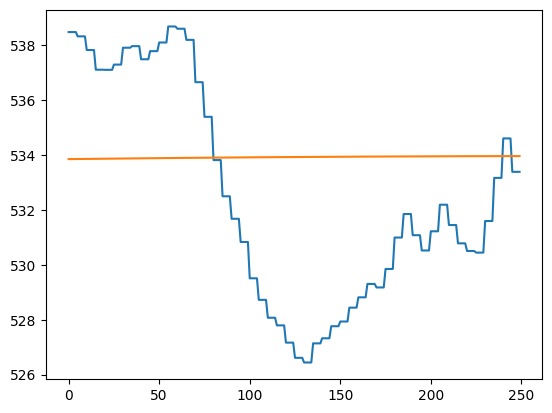

In [ ]:
plt.plot(np.repeat(past_laser_power,5))
plt.plot(GAMMA_class.GAMMA.laser_power_seq[:250])

In [ ]:
solution

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: tensor(21.1074)
       x: tensor([[-0.7746],
                  [-0.7757],
                  [-0.7753],
                  [-0.7706],
                  [-0.7655],
                  [-0.7607],
                  [-0.7560],
                  [-0.7525],
                  [-0.7513],
                  [-0.7521],
                  [-0.7546],
                  [-0.7579],
                  [-0.7618],
                  [-0.7654],
                  [-0.7688],
                  [-0.7713],
                  [-0.7725],
                  [-0.7735],
                  [-0.7732],
                  [-0.7709],
                  [-0.7658],
                  [-0.7571],
                  [-0.7450],
                  [-0.7300],
                  [-0.7127],
                  [-0.6895],
                  [-0.6627],
                  [-0.6320],
                  [-0.5957],
                  [-0.5561],
                  [-0.5146],


#### Objective function for scipy

In [ ]:
def RMPC_obj_wo_constraint_scipy(u_hat0:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_future_fix:torch.tensor, # future u values within the control horizon but not the design variables
                u_past:torch.tensor, # past u
                x_past_fix: torch.tensor, # past state of x, size (N,window)
                x_past:torch.tensor, # past state that changes
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal # NN object we're using
):
    ''' 
    All the data that goes into this model should be normalized
    '''    
    u_hat = torch.tensor(u_hat0.reshape(-1,1),requires_grad=True,dtype=torch.float32)
    u_hat_in = u_hat.unsqueeze(0)
    x_hat = NN_Nominal.forward(u_hat, u_future_fix, u_past, x_past_fix, x_past)

    # compute objective value

    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    u = u_hat_temp[0].reshape(-1,1)
    u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
    Obj = 100 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 0.1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)
    Obj.backward()

    
    return Obj.item(), u_hat.grad.numpy().reshape(-1)

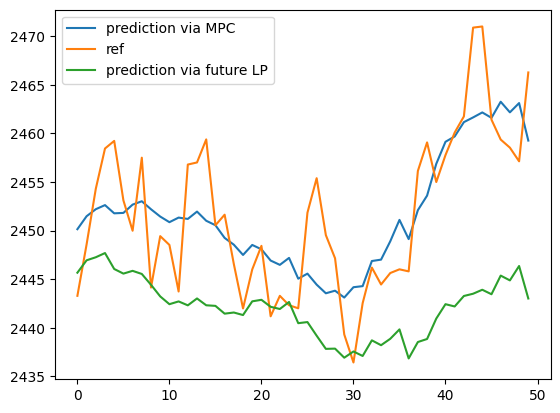

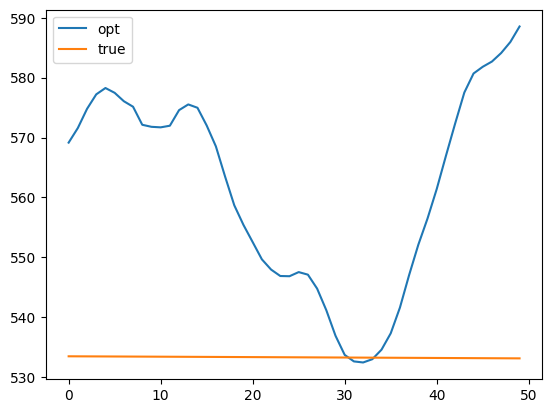

In [ ]:
#  === Initial Conditions: Values at time = k ===============
k = 200


# temporary ref 
mp_temp_ref_part = mp_temp_ref[k:k+P] + torch.tensor(np.linspace(0,30,50),dtype=torch.float32)
#mp_temp_ref_part = torch.tensor(np.ones(P)*3400,dtype=torch.float32)

mp_temp_ref_part_s = TiDE.scaler_y(mp_temp_ref_part)

# past melt pool temperature
mp_temp_past_part = mp_temp_ref[k-window:k]
mp_temp_past_part_s = TiDE.scaler_y(mp_temp_past_part).transpose(1,0)

# assume the past history is the same as the first term at the first step
fix_cov_past = fix_covariates[k-window:k,:]
fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2,3,4,5,6])

# fix future covariate
fix_cov_future = fix_covariates[k:k+P,:]
fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2,3,4,5,6])

# past laser power: take the given ones first
past_laser_power = laser_power_ref[k-window:k]
past_laser_power_s = TiDE.scaler_x(past_laser_power,dim_id=7)
future_laser_power = laser_power_ref[k:k+P]
future_laser_power_s = TiDE.scaler_x(future_laser_power,dim_id=7)

# designed laser power
u_hat = torch.zeros((P,1),dtype=torch.float32)
bounds = Bounds(lb=np.ones(P)*-1, ub=np.ones(P))
solution = minimize(lambda u:RMPC_obj_wo_constraint_scipy(u,fix_cov_future_s,past_laser_power_s,fix_cov_past_s, mp_temp_past_part_s,mp_temp_ref_part_s,P,TiDE),np.zeros((P)),method="slsqp",jac=True, bounds=bounds)

mp_hat_opt_s = TiDE.forward(torch.tensor(solution.x,dtype=torch.float32).reshape(-1,1), fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_hat_opt = TiDE.inv_scaler_y(mp_hat_opt_s)
mp_real_s = TiDE.forward(future_laser_power_s, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_real = TiDE.inv_scaler_y(mp_real_s)

plt.plot(mp_hat_opt.squeeze().detach().numpy(), label="prediction via MPC")
plt.plot(mp_temp_ref_part.numpy(), label="ref")
plt.plot(mp_real.detach().numpy().T, label='prediction via future LP')
plt.legend()
#plt.ylim([2200,2400])

plt.show()

plt.figure()
plt.plot(TiDE.inv_scaler_x(torch.tensor(solution.x),dim_id=7),label='opt')
plt.plot(TiDE.inv_scaler_x(future_laser_power_s,dim_id=7),label='true')
plt.legend()



In [ ]:
solution

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1483.9510498046875
       x: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
     nit: 4
     jac: [-4.321e+00 -3.603e+00 ... -6.816e+00 -9.895e+00]
    nfev: 4
    njev: 4